In [31]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
import torch.nn as nn
import numpy as np
import time
import onnx
import pickle
import onnxruntime as ort
import psutil, os
from pathlib import Path
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, RandomSampler, SubsetRandomSampler
from tqdm import tqdm
from dataset_impl import prepare_dataset, global_state_transformer
from train_rl_pipeline import DynamicsModel, Actor, Critic, SequenceSACNetwork, make_loaders  # adjust imports to your module layout
import os
import pandas as pd
from types import SimpleNamespace
from pprint import pprint
from scipy.signal import savgol_filter
import joblib
import netron

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("whitegrid")

In [32]:
def _to_np(x):
    return x.detach().cpu().numpy() if torch.is_tensor(x) else np.asarray(x)

def _moving_mean(arr, k=5):
    if k <= 1: return arr
    arr = _to_np(arr)
    filt = np.ones(k)/k
    return np.convolve(arr, filt, mode="same")

def dataset_ram_footprint(tbptt_ds, max_windows=None):
    """
    Rough RAM footprint of TBPTTVehicleDataset in bytes/MB/GB.
    
    Parameters
    ----------
    tbptt_ds     : the dataset returned by `prepare_dataset`
    max_windows  : int or None.  If set, only scan the first N windows
                   (useful for a quick estimate on HUGE datasets).
    """
    nbytes = 0
    it = range(len(tbptt_ds)) if max_windows is None else range(max_windows)
    for idx in tqdm(it, desc="Scanning windows"):
        s, a, ns, r, d = tbptt_ds[idx]      # each is a torch.Tensor
        # .numpy() would copy; tensor.storage().nbytes() works, but the
        # safest is to use the underlying NumPy array sizes we built from:
        nbytes += s.element_size()  * s.nelement()
        nbytes += a.element_size()  * a.nelement()
        nbytes += ns.element_size() * ns.nelement()
        nbytes += r.element_size()  * r.nelement()
        nbytes += d.element_size()  * d.nelement()

    mb = nbytes / (1024**2)
    gb = nbytes / (1024**3)
    print(f"\n≈ {mb:,.1f} MB  ({gb:,.2f} GB) for"
          f"{len(it):,} windows of length {tbptt_ds.seq_len}")
    return nbytes

In [33]:
def estimate_ram_usage(dataset, num_workers: int = 0):
    """
    Estimate RAM usage of an in-memory TBPTT dataset plus DataLoader workers.

    1) Bytes used by all stored windows (s, a, ns, r, d) in dataset.samples
    2) Current process RSS
    3) Pessimistic peak assuming each worker holds its own copy
    
    Args:
        dataset: your oldTBPTTVehicleDataset instance with `.samples = [...]`
        num_workers: number of DataLoader workers you'll spin up
    
    Returns:
        dict with keys 'data_bytes', 'data_MB', 'base_rss_MB', 'peak_rss_MB'
    """
    # 1) Sum bytes in all numpy arrays
    total_bytes = 0
    # dataset.samples is list of tuples (s_seq, a_seq, ns_seq, r_seq, d_seq)
    for (s_seq, a_seq, ns_seq, r_seq, d_seq) in dataset.samples:
        for arr in (s_seq, a_seq, ns_seq, r_seq, d_seq):
            total_bytes += arr.nbytes

    data_MB = total_bytes / 1024**2

    # 2) Current RSS
    proc = psutil.Process(os.getpid())
    base_rss = proc.memory_info().rss
    base_rss_MB = base_rss / 1024**2

    # 3) Pessimistic peak: main + one copy per worker
    peak_bytes = base_rss + num_workers * total_bytes
    peak_rss_MB = peak_bytes / 1024**2

    return {
        "data_bytes": total_bytes,
        "data_MB": data_MB,
        "base_rss_MB": base_rss_MB,
        "peak_rss_MB": peak_rss_MB,
        "num_workers": num_workers
    }

In [34]:
def plot_learning_curves(out_dir:Path, critic_losses, actor_losses, alpha_vals, raw_rewards, smooth=5):
    t = np.arange(len(critic_losses))

    fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
    ax = ax.ravel()

    ax[0].plot(t, critic_losses,  label="critic")
    ax[0].plot(t, _moving_mean(critic_losses,smooth), lw=2)
    ax[0].set_title("Critic loss")

    ax[1].plot(t, actor_losses,   label="actor",  color="tab:orange")
    ax[1].plot(t, _moving_mean(actor_losses,smooth), lw=2, color="tab:orange")
    ax[1].set_title("Actor loss")

    ax[2].plot(t, alpha_vals,  color="tab:green");  ax[2].set_title("α (entropy)")

    ax[3].plot(t, raw_rewards, color="tab:red")
    ax[3].plot(t, _moving_mean(raw_rewards,smooth), lw=2, color="tab:red")
    ax[3].set_title("Avg. un-shaped reward")

    for a in ax: a.set_xlabel("epoch")
    fig.tight_layout()
    fig.savefig(out_dir/"learning_curves.png", dpi=150)
    plt.close(fig)

In [35]:
def plot_pred_error_hist(true_next, pred_next, out_file):
    """
    true_next , pred_next : tensors [N, state_dim] or [*, S]  (flattened is fine)
    """
    err = F.mse_loss(pred_next, true_next, reduction="none")   # [*, S]
    err = err.pow(0.5).flatten().cpu().numpy()                 # L2 per dim
    plt.figure(figsize=(6,4))
    sns.histplot(err, bins=100, log_scale=(False, True))
    plt.xlabel("‖s_true – s_pred‖"); plt.ylabel("count (log)")
    plt.title("Dynamics 1-step prediction error")
    plt.tight_layout(); plt.savefig(out_file, dpi=150); plt.close()

In [36]:
def plot_residual_vs_q(residual, q_val, out_file):
    """
    residual : tensor [N]   (e.g. degradation abs-error)
    q_val    : tensor [N]   (min(Q1,Q2) at same timestep)
    """
    r = _to_np(residual); q = _to_np(q_val)
    plt.figure(figsize=(5,5))
    sns.scatterplot(x=q, y=r, s=8, alpha=0.3)
    plt.xlabel("Q value"); plt.ylabel("|residual|")
    corr = np.corrcoef(q, r)[0,1]
    plt.title(f"Residual vs Q  (ρ={corr:.2f})")
    plt.tight_layout(); plt.savefig(out_file, dpi=150); plt.close()

In [37]:
def plot_action_kde(gt_actions, pol_actions, out_file, labels=("GT","Policy")):
    """
    gt_actions , pol_actions : [N, action_dim]  → plots each dim separately
    """
    A = gt_actions.shape[-1]
    fig, ax = plt.subplots(A, 1, figsize=(6, 3*A))
    if A == 1: ax=[ax]
    for i in range(A):
        sns.kdeplot(_to_np(gt_actions[:,i]), ax=ax[i], label=labels[0])
        sns.kdeplot(_to_np(pol_actions[:,i]), ax=ax[i], label=labels[1])
        ax[i].set_ylabel(f"a[{i}]"); ax[i].legend()
    ax[-1].set_xlabel("value");  fig.tight_layout()
    fig.savefig(out_file, dpi=150); plt.close(fig)

In [38]:
def roll_forecast(actor, dynamics, init_state, horizon=1000, device="cpu"):
    """
    init_state : [1, 1, S]  (single step, batch=1, seq_len=1)
    Returns arrays of degr values over time for: GT-freezing vs. policy
    """
    actor.eval(); dynamics.eval()
    state = init_state.clone().to(device)          # last obs of a real window
    deg_idx = ...  # cache index

    deg_traj = []
    with torch.no_grad():
        for _ in range(horizon):
            act, _, _ = actor.sample(state)              # [1,1,A]
            ns, _, _, _ = dynamics(state, act)           # [1,1,S]
            deg_traj.append(ns[0,0,deg_idx].item())
            state = ns                                    # feed back

    return np.asarray(deg_traj)

def plot_long_roll(gt_last_deg, deg_traj, out_file):
    t = np.arange(len(deg_traj))
    plt.figure(figsize=(6,4))
    plt.plot(t, gt_last_deg*np.ones_like(t), '--', label="baseline (no further loss)")
    plt.plot(t, deg_traj, label="policy forecast")
    plt.xlabel("roll-out step"); plt.ylabel("battery degradation")
    plt.title("1000-step degradation forecast")
    plt.legend(); plt.tight_layout()
    plt.savefig(out_file, dpi=150); plt.close()

In [39]:
def load_training_logs(log_dir="logs"):
    """Load all training CSV logs into DataFrames"""
    logs = {}
    for log_file in os.listdir(log_dir):
        if log_file.endswith(".csv"):
            name = log_file.split(".")[0]
            logs[name] = pd.read_csv(os.path.join(log_dir, log_file))
    return logs

def plot_training_curves(log_df):
    """Plot key training metrics"""
    fig, ax = plt.subplots(3, 2, figsize=(15, 12))
    
    # Loss curves
    ax[0,0].plot(log_df['train_loss'], label='Train')
    ax[0,0].plot(log_df['val_loss'], label='Val')
    ax[0,0].set_title("Total Loss")
    ax[0,0].legend()
    
    # Component losses
    ax[0,1].plot(log_df['critic_loss'], label='Critic')
    ax[0,1].plot(log_df['actor_loss'], label='Actor')
    ax[0,1].set_title("Component Losses")
    ax[0,1].legend()
    
    # Alpha parameter
    ax[1,0].plot(log_df['alpha'])
    ax[1,0].set_title("Entropy Temperature (α)")
    
    # Rewards
    ax[1,1].plot(log_df['avg_raw_reward'])
    ax[1,1].set_title("Average Raw Reward")
    
    # Histograms
    ax[2,0].hist(log_df['critic_loss'], bins=50, alpha=0.7)
    ax[2,0].set_title("Critic Loss Distribution")
    
    ax[2,1].hist(log_df['actor_loss'], bins=50, alpha=0.7)
    ax[2,1].set_title("Actor Loss Distribution")
    
    plt.tight_layout()
    plt.show()

def load_models(model_dir="models", device=DEVICE):
    """Load saved model checkpoints"""
    models = {}

    # Dynamics Model
    dyn_model = DynamicsModel(len(feature_cols), len(action_cols), 3, 128).to(device)
    dyn_model.load_state_dict(torch.load(os.path.join(model_dir, "dynamic_model.pth")))
    models['dynamics'] = dyn_model
    
    # SAC Agent
    agent = SequenceSACNetwork(feature_cols, action_cols)
    agent.actor.load_state_dict(torch.load(os.path.join(model_dir, "sac_actor.pth")))
    agent.critic.load_state_dict(torch.load(os.path.join(model_dir, "sac_critic.pth")))
    models['agent'] = agent
    
    return models

def analyze_dynamics_predictions(dynamics_model, data_loader, feature_cols, n_samples=5):
    """Compare model predictions vs actual next states"""
    dynamics_model.eval()
    batch = next(iter(data_loader))
    s_seq, a_seq, ns_seq = [t.to(DEVICE) for t in (batch[0], batch[1], batch[2])]
    
    with torch.no_grad():
        preds = dynamics_model(s_seq[:,0], a_seq[:,0])
    
    actual = ns_seq[:,0].cpu().numpy()
    predicted = preds.cpu().numpy()
    
    # Plot feature-wise comparisons
    fig, ax = plt.subplots(3, 3, figsize=(15, 10))
    ax = ax.flatten()
    
    for i in range(min(len(feature_cols), 9)):
        ax[i].scatter(actual[:n_samples,i], predicted[:n_samples,i], alpha=0.6)
        ax[i].plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
        ax[i].set_title(feature_cols[i])
        ax[i].set_xlabel("Actual")
        ax[i].set_ylabel("Predicted")
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    mse = ((actual - predicted) ** 2).mean(axis=0)
    mae = np.abs(actual - predicted).mean(axis=0)
    
    return pd.DataFrame({'feature': feature_cols, 'mse': mse, 'mae': mae})

def policy_analysis(agent, data_loader):
    """Analyze policy behavior"""
    states, actions = [], []
    for batch in data_loader:
        s_seq = batch[0].to(DEVICE)
        with torch.no_grad():
            a_dist = agent.actor(s_seq)
            a = a_dist.sample()
        states.append(s_seq.cpu().numpy())
        actions.append(a.cpu().numpy())
    
    states = np.concatenate(states)
    actions = np.concatenate(actions)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].hist(actions.flatten(), bins=50)
    ax[0].set_title("Action Distribution")
    
    ax[1].scatter(states[:,deg_idx], actions[:,0], alpha=0.3)
    ax[1].set_xlabel("Battery Degradation")
    ax[1].set_ylabel("Action Value")
    ax[1].set_title("Actions vs Battery State")
    
    plt.tight_layout()
    plt.show()

def rollout_evaluation(agent, dynamics_model, initial_state, steps=100):
    """Simulate a trajectory using learned policy and dynamics"""
    state = torch.tensor(initial_state).float().to(DEVICE)
    trajectory = []
    
    for _ in range(steps):
        with torch.no_grad():
            action = agent.actor(state).sample()
            next_state = dynamics_model(state, action)
        
        trajectory.append({
            'state': state.cpu().numpy(),
            'action': action.cpu().numpy(),
            'next_state': next_state.cpu().numpy()
        })
        state = next_state
    
    # Convert to DataFrame for analysis
    df = pd.DataFrame(trajectory)
    df['degradation'] = df['state'].apply(lambda x: x[deg_idx])
    df['range'] = df['state'].apply(lambda x: x[rng_idx])
    df['speed'] = df['state'].apply(lambda x: x[speed_idx])
    
    # Plot key metrics
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    df['degradation'].plot(ax=ax[0,0], title="Battery Degradation")
    df['range'].plot(ax=ax[0,1], title="Vehicle Range")
    df['speed'].plot(ax=ax[1,0], title="Speed")
    pd.Series([a[0] for a in df.action]).plot(ax=ax[1,1], title="Actions")
    
    plt.tight_layout()
    plt.show()
    
    return df

In [ ]:
logs = load_training_logs()
sac_log = logs.get('sac_training')
if sac_log is not None:
    plot_training_curves(sac_log)

csv_dir="C:/Users/Mikkel/Downloads/thesis_rl_impl/logs_augmented/train"
csv_test_dir="C:/Users/Mikkel/Downloads/thesis_rl_impl/logs_augmented/test"

unnormalised_cols = ['sim_simulation_time', 'sim_dt_physics', 'sim_battery_time_accel']
numeric_cols = ['sim_speed', 'sim_front_rpm', 'sim_rear_rpm', 'sim_range', 
                'sim_battery_degradation', 'sim_battery_soh', 'sim_battery_temp', 
                'sim_battery_soc', 'sim_battery_curr', 'sim_battery_cooling_temp', 
                'carla_roll', 'carla_pitch', 'carla_yaw', 'carla_env_temp'
                ]
categorical_cols = ['sim_battery_age_factor', 'carla_traffic_light']
action_cols = ['sim_throttle', 'carla_steering']

#model settings
model       = f"a91c"
state_dim   = 22   # match your feature_cols length
action_dim  = 2
num_layers  = 2
hidden_size = 128
seq_len     = 64

# Run analysis
model_dir = Path(f"C:/Users/Mikkel/Downloads/thesis_rl_impl/checkpoints/Model_{model}/")
model = model_dir / f"dynamic_model_pretrain_{model}.pth"
ct = joblib.load(model_dir / "transformer.joblib")

sac_model = f"ef59"
SAC_model_dir = Path(f"C:/Users/Mikkel/Downloads/thesis_rl_impl/checkpoints/SAC_run_{sac_model}/")

train_loader, val_loader, feature_cols, _ = make_loaders(
    csv_dir=csv_dir, 
    unnormalised_cols=unnormalised_cols, 
    numeric_cols=numeric_cols, 
    categorical_cols=categorical_cols,
    action_cols=action_cols, 
    seq_len=seq_len,
    batch_size=64, 
    transformer=ct, 
    test=True
)

models = load_models(SAC_model_dir)
agent = models['agent']
dynamics_model = models['dynamics']

dyn_metrics = analyze_dynamics_predictions(dynamics_model, val_loader, feature_cols)
print("Dynamics Model Metrics:")
print(dyn_metrics)

policy_analysis(agent, val_loader)

initial_state = val_loader.dataset[0][0][0]  # First state of first sequence
rollout_df = rollout_evaluation(agent, dynamics_model, initial_state)

In [40]:
csv_dir="F:/Onedrive/Uni/MSc_uddannelse/4_semester/KandidatThesis/Thesis_Implementation/Scripts/RL_network/logs_augmented/train"
csv_test_dir="F:/Onedrive/Uni/MSc_uddannelse/4_semester/KandidatThesis/Thesis_Implementation/Scripts/RL_network/logs_augmented/test"

unnormalised_cols = ['sim_simulation_time', 'sim_dt_physics', 'sim_battery_time_accel']
numeric_cols = ['sim_speed', 'sim_front_rpm', 'sim_rear_rpm', 'sim_range', 
                'sim_battery_degradation', 'sim_battery_soh', 'sim_battery_temp',
                'sim_battery_soc', 'sim_battery_curr', 'sim_battery_cooling_temp', 
                'carla_roll', 'carla_pitch', 'carla_yaw', 'carla_env_temp'
                ]
categorical_cols = ['sim_battery_age_factor', 'carla_traffic_light']
action_cols = ['sim_throttle', 'carla_steering']

dataset, feature_cols, _ = prepare_dataset(csv_dir, unnormalised_cols, numeric_cols, categorical_cols, action_cols, seq_len=64, step=1)
print("≈ #windows:", len(dataset))
print("≈ #feature_cols:", len(feature_cols))

proc = psutil.Process(os.getpid())           # the process running this script
ram_mb = proc.memory_info().rss / 1024**2    # resident-set size → MiB
print(f"≈ RAM used : {ram_mb:,.1f} MB")

# quick sample to prove a slice still loads
state, action, next_state, reward, done = dataset[0]
print("sample shapes:", state.shape, action.shape, next_state.shape, reward.shape, done.shape)

dataset_ram_footprint(dataset, max_windows=None)

stats = estimate_ram_usage(dataset, num_workers=4)
print(f"Total windows data: {stats['data_MB']:.1f} MiB")
print(f"Current process RSS: {stats['base_rss_MB']:.1f} MiB")
print(f"Peak ≈ main + 4×copies: {stats['peak_rss_MB']:.1f} MiB")

Degradation stats - Mean: -0.00, Std: 1.00
≈ #windows: 790251
≈ #feature_cols: 22
≈ RAM used : 1,999.1 MB
sample shapes: torch.Size([64, 22]) torch.Size([64, 2]) torch.Size([64, 22]) torch.Size([64, 1]) torch.Size([64, 1])


Scanning windows: 100%|██████████| 790251/790251 [00:09<00:00, 82347.45it/s]



≈ 9,260.8 MB  (9.04 GB) for790,251 windows of length 64
Total windows data: 17749.8 MiB
Current process RSS: 1465.2 MiB
Peak ≈ main + 4×copies: 72464.4 MiB


In [44]:
def analyze_dynamics_model(model, test_loader, feature_names, save_dir: Path, device=DEVICE):
    """
    Enhanced dynamics model analysis with improved visualizations:
    - More intuitive True vs Predicted plots (swapped axes)
    - Added regression lines and R² scores
    - Better histogram visualization
    - Enhanced temporal error plots with confidence intervals
    - Cleaner feature importance visualization
    """
    save_dir.mkdir(parents=True, exist_ok=True)
    model.eval()
    
    # Storage
    deg_errs, rng_errs, spd_errs = [], [], []
    all_pred, all_true, seq_errs = [], [], []

    # Feature indices
    idx_deg = feature_names.index('num__sim_battery_degradation')
    idx_rng = feature_names.index('num__sim_range')
    idx_spd = feature_names.index('num__sim_speed')

    with torch.no_grad():
        for states, actions, next_states, _, _ in test_loader:
            states, actions, next_states = [t.to(device) for t in (states, actions, next_states)]
            pred_s, pred_d, pred_r, pred_v, _ = model(states[:, :-1], actions[:, :-1])

            # Store errors
            seq_errs.append(F.mse_loss(pred_s, next_states[:,1:], reduction='none').cpu().numpy())
            
            # Store scalar errors
            deg_errs.append(torch.sqrt(F.mse_loss(pred_d, next_states[:,1:,idx_deg].unsqueeze(-1))).item())
            rng_errs.append(torch.sqrt(F.mse_loss(pred_r, next_states[:,1:,idx_rng].unsqueeze(-1))).item())
            spd_errs.append(torch.sqrt(F.mse_loss(pred_v, next_states[:,1:,idx_spd].unsqueeze(-1))).item())

            all_pred.append(pred_s.cpu().numpy())
            all_true.append(next_states[:,1:].cpu().numpy())

    # Process stored data
    all_pred = np.concatenate(all_pred)
    all_true = np.concatenate(all_true)
    seq_errs = np.concatenate(seq_errs)

    # Calculate metrics
    global_metrics = {
        'degradation': np.mean(deg_errs),
        'range': np.mean(rng_errs),
        'speed': np.mean(spd_errs)
    }

    # Feature-wise errors
    mae_f = np.mean(np.abs(all_pred - all_true), axis=(0,1))
    df_err = pd.DataFrame({'feature': feature_names, 'mae': mae_f}).sort_values('mae', ascending=False)

    def save_fig(fig, name):
        path = save_dir / f"{name}.png"
        fig.savefig(path, bbox_inches='tight', dpi=300)
        plt.close(fig)

    # 1. Enhanced Error Distributions with Statistics
    def plot_error_distribution(errors, title, color='skyblue'):
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.histplot(errors, kde=True, color=color, ax=ax)
        ax.axvline(np.mean(errors), color='darkred', linestyle='--', 
                  label=f'Mean: {np.mean(errors):.4f}')
        ax.set_title(f"Error Distribution: {title}", pad=20)
        ax.set_xlabel("RMSE")
        ax.legend()
        return fig

    save_fig(plot_error_distribution(deg_errs, "Battery Degradation"), "dist_degradation")
    save_fig(plot_error_distribution(rng_errs, "Range", 'salmon'), "dist_range")
    save_fig(plot_error_distribution(spd_errs, "Speed", 'lightgreen'), "dist_speed")

    # 2. Enhanced True vs Predicted Plots with Regression
    def plot_scatter(true, pred, title, units=""):
        fig = plt.figure(figsize=(10, 8))
        g = sns.jointplot(x=true, y=pred, kind='reg', 
                        joint_kws={'scatter_kws': {'alpha': 0.3, 'color': 'navy'},
                                  'line_kws': {'color': 'darkred'}},
                        marginal_kws={'color': 'navy'})
        
        # Calculate regression stats
        slope, intercept = np.polyfit(true, pred, 1)
        r2 = r2_score(true, pred)
        
        # Set axis labels according to user preference
        g.ax_joint.set_xlabel(f"True {title} {units}", fontsize=12)
        g.ax_joint.set_ylabel(f"Predicted {title} {units}", fontsize=12)
        
        # Add annotation box
        text = (f"R²: {r2:.3f}\n"
                f"Slope: {slope:.3f}\n"
                f"Intercept: {intercept:.3f}")
        g.ax_joint.text(0.05, 0.95, text, transform=g.ax_joint.transAxes,
                       verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        return g.fig

    # Range plot
    t_rng = all_true[..., idx_rng].ravel()
    p_rng = all_pred[..., idx_rng].ravel()
    save_fig(plot_scatter(t_rng, p_rng, "Range", "(km)"), "scatter_range")

    # Speed plot
    t_spd = all_true[..., idx_spd].ravel()
    p_spd = all_pred[..., idx_spd].ravel()
    save_fig(plot_scatter(t_spd, p_spd, "Speed", "(km/h)"), "scatter_speed")

    # 3. Temporal Error Analysis with Confidence Intervals
    def plot_temporal_error(seq_errs):
        fig, ax = plt.subplots(figsize=(12, 6))
        mean_err = seq_errs.mean(axis=(0, 2))
        std_err = seq_errs.std(axis=(0, 2))
        
        ax.plot(mean_err, label='Mean Error', color='darkblue')
        ax.fill_between(range(len(mean_err)), 
                       mean_err - std_err, 
                       mean_err + std_err, 
                       alpha=0.3, color='lightblue',
                       label='±1 Std Dev')
        
        ax.set_title("Temporal Error Progression with Confidence Bands", pad=15)
        ax.set_xlabel("Time Step")
        ax.set_ylabel("MSE")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
        return fig

    save_fig(plot_temporal_error(seq_errs), "temporal_error")

    # 4. Enhanced Feature Importance Plot
    def plot_feature_importance(df_err):
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.barplot(
            x='mae', 
            y='feature', 
            data=df_err.head(15), 
            palette='viridis', 
            ax=ax,
            legend=False,
            hue='feature'
            )
        ax.set_title("Top 15 Features by Mean Absolute Error", pad=15)
        ax.set_xlabel("Mean Absolute Error (MAE)")
        ax.set_ylabel("Feature Name")
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        return fig

    save_fig(plot_feature_importance(df_err), "feature_mae")

    print(f"\nAnalysis complete. Results saved to: {save_dir}")
    return global_metrics, df_err

In [45]:
#model settings
model       = f"fcee"
state_dim   = 22   # match your feature_cols length
action_dim  = 2
num_layers  = 3
hidden_size = 128
seq_len     = 64
# Run analysis
model_dir = Path(f"F:/Onedrive/Uni/MSc_uddannelse/4_semester/KandidatThesis/Thesis_Implementation/Scripts/RL_network/checkpoints/Model_{model}/")
model = model_dir / f"dynamic_model_pretrain_{model}.pth"
ct = joblib.load(model_dir / "transformer.joblib")

In [ ]:
csv_test_dir="F:/Onedrive/Uni/MSc_uddannelse/4_semester/KandidatThesis/Thesis_Implementation/Scripts/RL_network/logs_augmented/test"

# Load your trained dynamics model
dynamics_model = DynamicsModel(
    state_dim=state_dim,
    action_dim=action_dim,
    num_layers=num_layers,
    hidden_size=hidden_size
).to(DEVICE)

dynamics_model.load_state_dict(torch.load(model))

# Create test loader
test_loader, _, feature_cols, _ = make_loaders(
    csv_dir=csv_test_dir,
    unnormalised_cols=unnormalised_cols,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    transformer=ct,
    action_cols=action_cols,
    test=True
)

pprint(f"feature lengths: {len(feature_cols)}")
pprint(f"feature cols: {feature_cols}")

analyze_dynamics_model(
    model=dynamics_model,
    test_loader=test_loader,
    feature_names=feature_cols,
    save_dir=model_dir
)

Degradation stats - Mean: -0.59, Std: 0.24
'feature lengths: 22'
("feature cols: ['age__sim_battery_age_factor_1', "
 "'age__sim_battery_age_factor_5', 'age__sim_battery_age_factor_20', "
 "'num__sim_speed', 'num__sim_front_rpm', 'num__sim_rear_rpm', "
 "'num__sim_range', 'num__sim_battery_degradation', 'num__sim_battery_soh', "
 "'num__sim_battery_temp', 'num__sim_battery_soc', 'num__sim_battery_curr', "
 "'num__sim_battery_cooling_temp', 'num__carla_env_temp', "
 "'ang__carla_roll_sin', 'ang__carla_roll_cos', 'ang__carla_pitch_sin', "
 "'ang__carla_pitch_cos', 'ang__carla_yaw_sin', 'ang__carla_yaw_cos', "
 "'cat__carla_traffic_light_0', 'cat__carla_traffic_light_1']")


In [ ]:
def test_single_window(
    dynamics_ckpt: str,
    save_dir: str,
    csv_dir: str,
    unnormalised_cols: list,
    numeric_cols: list,
    categorical_cols: list,
    action_cols: list,
    transformer,
    seq_len: int = 64,
    num_layers: int = 2,
    hidden_size: int = 128,
    device: str = "cpu"
):
    """
    Load one sequence from csv_dir, run a single-window rollout through the dynamics model,
    and plot:
      - 1 combined figure (all signals overlayed)
      - 1 separate subplot per signal (degradation, range, speed, battery_curr, soh, soc, cooling_temp, front_rpm, rear_rpm)
    """

    # --- 1) Prepare a single-window dataset & loader -------------------
    ds, feature_cols, ct = prepare_dataset(
        csv_dir,
        unnormalised_cols,
        numeric_cols,
        categorical_cols,
        action_cols,
        seq_len=seq_len,
        transformer=transformer,
        step=1
    )
    loader = DataLoader(ds, batch_size=1, shuffle=True)
    
    # grab one window
    states, actions, next_states, _, _ = next(iter(loader))
    states = states.to(device)          # [1, T, S]
    actions = actions.to(device)        # [1, T, A]
    next_states = next_states.to(device)

    # --- 2) Load your dynamics model -----------------------------------
    model = DynamicsModel(
        state_dim = len(feature_cols),
        action_dim= len(action_cols),
        num_layers= num_layers,
        hidden_size= hidden_size
    ).to(device)
    model.load_state_dict(torch.load(dynamics_ckpt, map_location=device))
    model.eval()

    # --- 3) Run one-step rollout ---------------------------------------
    with torch.no_grad():
        pred_states, pred_deg, pred_range, pred_speed, _ = model(
            states[:, :-1], actions[:, :-1]
        )

    # squeeze out batch & time dims
    T = seq_len
    pred_states   = pred_states[0].cpu().numpy()      # [T, S]
    true_states   = next_states[0].cpu().numpy()[1:]  # [T, S]
    pred_deg      = pred_deg[0,:,0].cpu().numpy()     # [T]
    true_deg      = true_states[:, feature_cols.index('num__sim_battery_degradation')]
    pred_range    = pred_range[0,:,0].cpu().numpy()
    true_range    = true_states[:, feature_cols.index('num__sim_range')]
    pred_speed    = pred_speed[0,:,0].cpu().numpy()
    true_speed    = true_states[:, feature_cols.index('num__sim_speed')]

    # helper to pull out any column by name
    def get_col(array, name):
        idx = feature_cols.index(name)
        return array[:, idx]

    # battery signals:
    true_curr     = get_col(true_states,  'num__sim_battery_curr')
    pred_curr     = pred_states[:, feature_cols.index('num__sim_battery_curr')]
    true_soh      = get_col(true_states,  'num__sim_battery_soh')
    pred_soh      = pred_states[:, feature_cols.index('num__sim_battery_soh')]
    true_soc      = get_col(true_states,  'num__sim_battery_soc')
    pred_soc      = pred_states[:, feature_cols.index('num__sim_battery_soc')]
    true_cool     = get_col(true_states,  'num__sim_battery_cooling_temp')
    pred_cool     = pred_states[:, feature_cols.index('num__sim_battery_cooling_temp')]
    true_frpm     = get_col(true_states,  'num__sim_front_rpm')
    pred_frpm     = pred_states[:, feature_cols.index('num__sim_front_rpm')]
    true_rrpm     = get_col(true_states,  'num__sim_rear_rpm')
    pred_rrpm     = pred_states[:, feature_cols.index('num__sim_rear_rpm')]

    # --- 4) Plotting ----------------------------------------------------
    times = np.arange(1, T)  # because next_states starts at t=1

    def save_fig(fig, name):
        path = save_dir / f"{name}.png"
        fig.savefig(path, bbox_inches='tight')
        plt.close(fig)

    # 4a) Combined overlay
    fig = plt.figure(figsize=(12,4))
    for name, t, p in [
        ("degradation", true_deg, pred_deg),
        ("range",       true_range, pred_range),
        ("speed",       true_speed, pred_speed),
        ("current",     true_curr, pred_curr),
        ("SoH",         true_soh, pred_soh),
        ("SoC",         true_soc, pred_soc),
        ("cool_temp",   true_cool, pred_cool),
        ("front_rpm",   true_frpm, pred_frpm),
        ("rear_rpm",    true_rrpm, pred_rrpm),
    ]:
        plt.plot(times, t,   label=f"GT {name}", alpha=0.6)
        plt.plot(times, p, '--', label=f"PR {name}", alpha=0.8)
    plt.title("Single-window True vs Predicted (all signals)")
    plt.xlabel("Time step")
    plt.legend(loc="upper left", ncol=2, fontsize="small")
    plt.tight_layout()
    save_fig(fig, "singular_window")
    plt.show()

    # 4b) One subplot per variable
    vars = [
        ("Battery Deg", true_deg, pred_deg),
        ("Range",       true_range, pred_range),
        ("Speed",       true_speed, pred_speed),
        ("Battery Curr",true_curr, pred_curr),
        ("SoH",         true_soh, pred_soh),
        ("SoC",         true_soc, pred_soc),
        ("Cool Temp",   true_cool, pred_cool),
        ("Front RPM",   true_frpm, pred_frpm),
        ("Rear RPM",    true_rrpm, pred_rrpm),
    ]
    n = len(vars)
    cols = 3
    rows = (n + cols - 1)//cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharex=True)
    axes = axes.flatten()
    for ax, (title, t, p) in zip(axes, vars):
        ax.plot(times, t,   label="GT", alpha=0.6)
        ax.plot(times, p, '--', label="PR", alpha=0.8)
        ax.set_title(title)
        ax.legend(fontsize="x-small")
    for ax in axes[n:]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
def test_single_window(
    dynamics_ckpt: str,
    save_dir: str,
    csv_dir: str,
    unnormalised_cols: list,
    numeric_cols: list,
    categorical_cols: list,
    action_cols: list,
    transformer,
    seq_len: int = 64,
    num_layers: int = 2,
    hidden_size: int = 128,
    device: str = "cpu"
):
    """
    Robust single-window visualization with shape validation
    """
    # --- 1) Prepare dataset & load model --------------------------------
    ds, feature_cols, ct = prepare_dataset(
        csv_dir, unnormalised_cols, numeric_cols, categorical_cols, action_cols,
        seq_len=seq_len, transformer=transformer, step=1
    )
    loader = DataLoader(ds, batch_size=1, shuffle=True)
    states, actions, next_states, _, _ = next(iter(loader))
    
    model = DynamicsModel(
        state_dim=len(feature_cols),
        action_dim=len(action_cols),
        num_layers=num_layers,
        hidden_size=hidden_size
    ).to(device)
    model.load_state_dict(torch.load(dynamics_ckpt, map_location=device))
    model.eval()

    # --- 2) Run prediction ---------------------------------------------
    with torch.no_grad():
        # Use all but the last state for prediction
        pred_states, pred_deg, pred_range, pred_speed, _ = model(
            states[:, :-1].to(device), 
            actions[:, :-1].to(device)
        )
    
    # Convert to numpy
    true_states = next_states[0].cpu().numpy()
    pred_states = pred_states[0].cpu().numpy()
    
    # Determine actual sequence length
    n_steps = min(pred_states.shape[0], true_states.shape[0]-1)
    times = np.arange(1, n_steps+1)
    
    # Slice arrays to consistent length
    true_states = true_states[1:1+n_steps]  # Skip first state
    pred_states = pred_states[:n_steps]
    
    # --- 3) Plotting ---------------------------------------------------
    plt.style.use('seaborn-v0_8-poster')
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'figure.dpi': 300,
        'savefig.dpi': 300
    })
    
    # Helper function to get data with shape validation
    def get_data(true, pred, name):
        idx = feature_cols.index(name)
        return true[:, idx], pred[:, idx]
    
    # Select key signals for visualization
    key_signals = [
        ('num__sim_battery_degradation', 'Degradation (%)'),
        ('num__sim_battery_soh', 'State of Health (%)'),
        ('num__sim_battery_soc', 'State of Charge (%)'),
        ('num__sim_battery_curr', 'Current (A)'),
        ('num__sim_speed', 'Speed (km/h)'),
        ('num__sim_range', 'Range (km)'),
        ('num__sim_front_rpm', 'Front RPM'),
        ('num__sim_rear_rpm', 'Rear RPM'),
        ('num__sim_battery_cooling_temp', 'Cooling Temp (°C)')
    ]
    
    # Create figure with subplots
    n_signals = len(key_signals)
    n_cols = 3
    n_rows = (n_signals + n_cols - 1) // n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axs = axs.flatten()
    
    # Plot each signal in its own subplot
    for i, (signal, label) in enumerate(key_signals):
        t, p = get_data(true_states, pred_states, signal)
        ax = axs[i]
        ax.plot(times, t, 'b-', label='Ground Truth', alpha=0.8)
        ax.plot(times, p, 'r--', label='Predicted', alpha=0.8)
        ax.set_title(label)
        ax.set_xlabel('Time Step')
        ax.grid(True, alpha=0.3)
        
        # Add metrics to legend
        mae = np.mean(np.abs(t - p))
        rmse = np.sqrt(np.mean((t - p)**2))
        ax.legend(title=f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}', fontsize=9)
    
    # Hide unused subplots
    for j in range(i+1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_dir / "signal_comparison.png", bbox_inches='tight')
    plt.close()
    
    # --- 4) Error analysis ---------------------------------------------
    # Error distribution plot
    errors = []
    labels = []
    for signal, label in key_signals:
        t, p = get_data(true_states, pred_states, signal)
        err = t - p
        errors.extend(err.tolist())
        labels.extend([label] * len(err))
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=labels, y=errors, showfliers=False)
    plt.axhline(0, color='r', linestyle='--', alpha=0.5)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Signal')
    plt.ylabel('Error (True - Predicted)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(save_dir / "error_distribution.png")
    plt.close()
    
    # --- 5) Action visualization ---------------------------------------
    throttle = actions[0, :n_steps, 0].numpy()
    steering = actions[0, :n_steps, 1].numpy()
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    axs[0].plot(times, throttle, 'b-', label='Throttle')
    axs[0].set_ylabel('Throttle Position [0-1]')
    axs[0].set_title('Control Input Sequence')
    axs[0].grid(True, alpha=0.3)
    
    axs[1].plot(times, steering, 'g-', label='Steering')
    axs[1].set_ylabel('Steering Angle [-1,1]')
    axs[1].set_xlabel('Time Step')
    axs[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_dir / "control_sequence.png")
    plt.close()
    
    # --- 6) Metrics table ----------------------------------------------
    metrics = []
    for signal, label in key_signals:
        t, p = get_data(true_states, pred_states, signal)
        err = t - p
        metrics.append({
            'Signal': label,
            'MAE': np.mean(np.abs(err)),
            'RMSE': np.sqrt(np.mean(err**2)),
            'Max Error': np.max(np.abs(err)),
            'Correlation': np.corrcoef(t, p)[0, 1]
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    # Save metrics to CSV
    metrics_df.to_csv(save_dir / "performance_metrics.csv", index=False)
    
    print(f"Saved visualizations to: {save_dir}")
    print("Performance Metrics:")
    print(metrics_df)
    
    return metrics_df

In [ ]:
metrics = test_single_window(
    dynamics_ckpt = model,
    save_dir = model_dir,
    csv_dir = "logs_augmented/test",
    unnormalised_cols = unnormalised_cols,
    numeric_cols = numeric_cols,
    categorical_cols = categorical_cols,
    action_cols = action_cols,
    transformer = ct,
    seq_len = 64,
    num_layers = 3,
    hidden_size = 128,
    device = "cuda" if torch.cuda.is_available() else "cpu"
)

print("Single-window test completed. Metrics:")
print(metrics)

In [ ]:
def eval_full_drive(
    csv_path: str,
    model: nn.Module,
    csv_train_folder: str,
    unnormalised_cols: list[str],
    numeric_cols: list[str],
    categorical_cols: list[str],
    action_cols: list[str],
    transformer,  # Should be a fitted ColumnTransformer
    model_save_dir: str,
    device: str = "cpu"
):
    """
    Enhanced full drive evaluation with:
    - Regression lines and R² scores in scatter plots
    - Improved time-series visualization
    - Better error statistics
    - Cleaner styling and labeling
    """
    import os
    import numpy as np
    import pandas as pd
    import torch
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score  # Added import
    
    # 1) Get feature names from the transformer
    feature_names = transformer.get_feature_names_out().tolist()
    
    # 2) Load & transform the full drive sequence
    df = pd.read_csv(csv_path)
    S = transformer.transform(df[unnormalised_cols + numeric_cols + categorical_cols]).astype(np.float32)
    A = df[action_cols].values.astype(np.float32)

    # 3) Prepare tensors [1, T, *]
    states = torch.from_numpy(S).unsqueeze(0).float().to(device)
    actions = torch.from_numpy(A).unsqueeze(0).float().to(device)

    # 4) Run model prediction
    model.to(device).eval()
    with torch.no_grad():
        pred_state, pred_deg, pred_rng, pred_spd, _ = model(
            states[:, :-1], actions[:, :-1]
        )

    # 5) Convert to numpy arrays
    true_states = S[1:]               # [T-1, S]
    ps = pred_state.cpu().numpy()[0]  # [T-1, S]
    deg = pred_deg.cpu().numpy()[0,:,0]
    rng = pred_rng.cpu().numpy()[0,:,0]
    spd = pred_spd.cpu().numpy()[0,:,0]

    # 6) Locate feature indices
    idx_deg = feature_names.index("num__sim_battery_degradation")
    idx_rng = feature_names.index("num__sim_range")
    idx_spd = feature_names.index("num__sim_speed")
    idx_curr = feature_names.index("num__sim_battery_curr")

    os.makedirs(model_save_dir, exist_ok=True)

    # === Enhanced 2×2 Scatter Plots ===
    def create_scatter_plot(ax, true, pred, title, units=""):
        """Create enhanced scatter plot with regression line and stats"""
        # Plot data
        sns.regplot(x=true, y=pred, ax=ax, scatter_kws={'alpha': 0.4, 'color': 'navy'}, 
                   line_kws={'color': 'darkred', 'lw': 1.5})
        
        # Calculate statistics
        r2 = r2_score(true, pred)
        mae = np.mean(np.abs(true - pred))
        
        # Format annotation
        stats_text = (f"R²: {r2:.3f}\nMAE: {mae:.3f}")
        ax.annotate(stats_text, xy=(0.05, 0.85), xycoords='axes fraction',
                   bbox=dict(facecolor='white', alpha=0.8))
        
        # Format labels
        ax.set_xlabel(f"Ground Truth {title} {units}", fontsize=10)
        ax.set_ylabel(f"Predicted {title} {units}", fontsize=10)
        ax.set_title(f"{title} Prediction", pad=12, fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    specs = [
        ("Degradation", true_states[:, idx_deg], deg, ""),
        ("Range", true_states[:, idx_rng], rng, "(km)"),
        ("Speed", true_states[:, idx_spd], spd, "(km/h)"),
        ("Current", true_states[:, idx_curr], ps[:, idx_curr], "(A)"),
    ]

    for i, (title, true_vals, pred_vals, units) in enumerate(specs):
        row, col = divmod(i, 2)
        create_scatter_plot(axes[row, col], true_vals, pred_vals, title, units)
    
    plt.tight_layout()
    fig.savefig(os.path.join(model_save_dir, "full_drive_scatter.png"), dpi=150)
    plt.close(fig)

    # === Enhanced Time-Series Plots ===
    def create_time_series_plot(true, pred, title, units=""):
        """Create enhanced time-series comparison plot"""
        fig, ax = plt.subplots(figsize=(14, 5))
        
        # Plot data
        ax.plot(true, label='Ground Truth', color='#2c7bb6', lw=2, alpha=0.9)
        ax.plot(pred, label='Prediction', color='#d7191c', lw=1.5, linestyle='--')

        #plot smoothed prediction
        pred_smooth = savgol_filter(pred, window_length=250, polyorder=4)
        ax.plot(pred_smooth, label='Smoothed Prediction', color="#f3fd61", lw=1.5)
                
        # Calculate and plot errors
        #errors = pred - true
        #ax.fill_between(np.arange(len(errors)), errors, alpha=0.2, 
        #               color='#fdae61', label='Prediction Error')
        
        # Format plot
        ax.set_title(f"{title} Evolution", pad=15, fontsize=14)
        ax.set_xlabel("Time Step", fontsize=12)
        ax.set_ylabel(f"{title} {units}", fontsize=12)
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.6)
        return fig

    for title, true_vals, pred_vals, units in specs:
        fig = create_time_series_plot(
            true_vals, pred_vals, title, units
        )
        fig.savefig(os.path.join(
            model_save_dir, f"full_drive_ts_{title.lower()}.png"
        ), dpi=150)
        plt.close(fig)

    print(f"✅ Saved all enhanced plots to {model_save_dir}")

In [ ]:
def eval_full_drive(
    csv_path: str,
    model: nn.Module,
    csv_train_folder: str,
    unnormalised_cols: list[str],
    numeric_cols: list[str],
    categorical_cols: list[str],
    action_cols: list[str],
    transformer,
    model_save_dir: str,
    device: str = "cpu"
):
    """
    Professional full drive evaluation for master thesis with:
    - Publication-quality visualizations
    - Comprehensive error metrics and statistics
    - Enhanced time-series analysis
    - Battery degradation focus
    """
    import os
    import numpy as np
    import pandas as pd
    import torch
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    import seaborn as sns
    from scipy.signal import savgol_filter
    
    # Setup professional styling
    plt.style.use('seaborn-v0_8-poster')
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'legend.fontsize': 12
    })
    
    # Create output directory
    os.makedirs(model_save_dir, exist_ok=True)
    
    # 1) Get feature names from the transformer
    feature_names = transformer.get_feature_names_out().tolist()
    
    # 2) Load & transform the full drive sequence
    df = pd.read_csv(csv_path)
    cuDNN_limit = 63535  # Limit for cuDNN performance
    df = df[:cuDNN_limit]
    S = transformer.transform(df[unnormalised_cols + numeric_cols + categorical_cols]).astype(np.float32)
    A = df[action_cols].values.astype(np.float32)
    
    # Calculate drive duration
    time_seconds = np.arange(len(df)) * 0.1  # Assuming 10Hz data
    drive_duration = time_seconds[-1] / 60  # Convert to minutes

    # 3) Prepare tensors
    states = torch.from_numpy(S).unsqueeze(0).float().contiguous().to(device)
    actions = torch.from_numpy(A).unsqueeze(0).float().contiguous().to(device)
    
    #print(states.is_contiguous())  # Should be True
    #print(actions.is_contiguous()) # Should be True
    #print(states.shape)

    # 4) Run model prediction
    model.to(device).eval()
    with torch.no_grad():
        pred_state, pred_deg, pred_rng, pred_spd, _ = model(
            states[:, :-1], actions[:, :-1]
        )

    # 5) Convert to numpy arrays
    true_states = S[1:]               # [T-1, S]
    ps = pred_state.cpu().numpy()[0]  # [T-1, S]
    deg = pred_deg.cpu().numpy()[0,:,0]
    rng = pred_rng.cpu().numpy()[0,:,0]
    spd = pred_spd.cpu().numpy()[0,:,0]

    # 6) Locate feature indices
    idx_deg = feature_names.index("num__sim_battery_degradation")
    idx_rng = feature_names.index("num__sim_range")
    idx_spd = feature_names.index("num__sim_speed")
    idx_curr = feature_names.index("num__sim_battery_curr")
    idx_soh = feature_names.index("num__sim_battery_soh")
    idx_soc = feature_names.index("num__sim_battery_soc")
    idx_temp = feature_names.index("num__sim_battery_cooling_temp")

    # === Enhanced Scatter Plots ===
    def create_scatter_plot(ax, true, pred, title, units=""):
        """Enhanced scatter plot with regression line and statistics"""
        # Calculate metrics
        r2 = r2_score(true, pred)
        mae = mean_absolute_error(true, pred)
        rmse = np.sqrt(mean_squared_error(true, pred))
        
        # Create regression plot
        sns.regplot(
            x=true, y=pred, ax=ax, 
            scatter_kws={'s': 15, 'alpha': 0.4, 'color': '#1f77b4'},
            line_kws={'color': '#d62728', 'lw': 2}
        )
        
        # Add identity line
        lims = [min(true.min(), pred.min()), max(true.max(), pred.max())]
        ax.plot(lims, lims, 'k--', alpha=0.5, lw=1)
        
        # Add statistics box
        stats_text = f"R² = {r2:.3f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}"
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=props, fontsize=11)
        
        # Format labels
        ax.set_xlabel(f"Ground Truth {title} {units}", fontsize=12)
        ax.set_ylabel(f"Predicted {title} {units}", fontsize=12)
        ax.set_title(f"{title} Prediction", fontsize=14)
        ax.grid(True, alpha=0.3)
        return r2, mae, rmse

    # Create subplots for key metrics
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    metrics_data = []
    
    specs = [
        ("Degradation", true_states[:, idx_deg], deg, "(%)"),
        ("Range", true_states[:, idx_rng], rng, "(km)"),
        ("Speed", true_states[:, idx_spd], spd, "(km/h)"),
        ("Current", true_states[:, idx_curr], ps[:, idx_curr], "(A)"),
    ]

    for i, (title, true_vals, pred_vals, units) in enumerate(specs):
        row, col = i // 2, i % 2
        r2, mae, rmse = create_scatter_plot(
            axes[row, col], true_vals, pred_vals, title, units
        )
        metrics_data.append({
            'Signal': title,
            'R²': r2,
            'MAE': mae,
            'RMSE': rmse,
            'Units': units
        })
    
    plt.tight_layout()
    fig.savefig(os.path.join(model_save_dir, "full_drive_scatter.png"))
    plt.close(fig)

    # === Enhanced Time-Series Plots ===
    def create_time_series_plot(true, pred, title, units="", ax=None):
        """Enhanced time-series plot with smoothing and error metrics"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(14, 5))
            standalone = True
        else:
            standalone = False
            
        # Calculate metrics
        mae = mean_absolute_error(true, pred)
        rmse = np.sqrt(mean_squared_error(true, pred))
        
        # Apply smoothing to predictions
        window = min(251, len(pred) // 10)  # Ensure window is appropriate size
        if window % 2 == 0:  # Savitzky-Golay requires odd window size
            window += 1
        pred_smooth = savgol_filter(pred, window_length=window, polyorder=3)
        
        # Plot data
        ax.plot(time_seconds[1:], true, label='Ground Truth', color='#2c7bb6', lw=2, alpha=0.9)
        ax.plot(time_seconds[1:], pred, label='Prediction', color='#d7191c', lw=1, alpha=0.4)
        ax.plot(time_seconds[1:], pred_smooth, label='Smoothed Prediction', color='#fdae61', lw=1.8)
        
        # Add error metrics
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax.text(0.05, 0.95, f"MAE: {mae:.3f}{units}\nRMSE: {rmse:.3f}{units}", 
                transform=ax.transAxes, verticalalignment='top', bbox=props)
        
        # Format plot
        ax.set_title(f"{title} Evolution", fontsize=14)
        ax.set_xlabel("Time (seconds)", fontsize=12)
        ax.set_ylabel(f"{title} {units}", fontsize=12)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        
        if standalone:
            return fig, mae, rmse
        return mae, rmse

    # Create combined degradation plot
    fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Degradation plot
    mae_deg, rmse_deg = create_time_series_plot(true_states[:, idx_deg], deg, "Battery Degradation", "(%)", axs[0])
    
    # State of Health plot
    soh_true = true_states[:, idx_soh]
    soh_pred = ps[:, idx_soh]
    mae_soh, rmse_soh = create_time_series_plot(soh_true, soh_pred, "State of Health", "(%)", axs[1])
    
    plt.tight_layout()
    fig.savefig(os.path.join(model_save_dir, "full_drive_battery_health.png"))
    plt.close(fig)
    
    # Add battery metrics to data
    metrics_data.append({
        'Signal': 'Battery Degradation',
        'R²': r2_score(true_states[:, idx_deg], deg),
        'MAE': mae_deg,
        'RMSE': rmse_deg,
        'Units': '(%)'
    })
    metrics_data.append({
        'Signal': 'State of Health',
        'R²': r2_score(soh_true, soh_pred),
        'MAE': mae_soh,
        'RMSE': rmse_soh,
        'Units': '(%)'
    })

    # Create combined performance plot
    fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    create_time_series_plot(true_states[:, idx_spd], spd, "Speed", "(km/h)", axs[0])# Speed plo
    create_time_series_plot(true_states[:, idx_rng], rng, "Range", "(km)", axs[1])# Range plot
    create_time_series_plot(true_states[:, idx_curr], ps[:, idx_curr], "Battery Current", "(A)", axs[2]) # Current plot
    
    plt.tight_layout()
    fig.savefig(os.path.join(model_save_dir, "full_drive_performance.png"))
    plt.close(fig)

    # === Degradation Analysis ===
    # Calculate degradation rate
    deg_start = true_states[0, idx_deg]
    deg_end = true_states[-1, idx_deg]
    pred_deg_end = deg[-1]
    
    deg_rate_true = (deg_end - deg_start) / (time_seconds[-1] / 3600)  # %/hour
    deg_rate_pred = (pred_deg_end - deg_start) / (time_seconds[-1] / 3600)
    
    # Create degradation analysis plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Cumulative degradation
    ax1.plot(time_seconds[1:], true_states[:, idx_deg], 'b-', label='True Degradation')
    ax1.plot(time_seconds[1:], deg, 'r--', label='Predicted Degradation')
    ax1.set_title(f"Battery Degradation\nTrue Rate: {deg_rate_true:.4f}%/hr | Pred Rate: {deg_rate_pred:.4f}%/hr")
    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Degradation (%)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Degradation rate
    deg_rate_true_ts = np.gradient(true_states[:, idx_deg], time_seconds[1:]) * 3600  # %/hour
    deg_rate_pred_ts = np.gradient(deg, time_seconds[1:]) * 3600
    ax2.plot(time_seconds[1:], deg_rate_true_ts, 'b-', label='True Degradation Rate')
    ax2.plot(time_seconds[1:], deg_rate_pred_ts, 'r--', label='Predicted Degradation Rate')
    ax2.set_title("Degradation Rate")
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Degradation Rate (%/hr)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig.savefig(os.path.join(model_save_dir, "full_drive_degradation_analysis.png"))
    plt.close(fig)
    
    # === Action Sequence Visualization ===
    throttle = actions[0, :-1, 0].cpu().numpy()
    steering = actions[0, :-1, 1].cpu().numpy()
    
    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Throttle
    axs[0].plot(time_seconds[1:], throttle, 'b-', label='Throttle')
    axs[0].set_ylabel("Throttle Position [0-1]")
    axs[0].set_title("Control Input Sequence")
    axs[0].grid(True, alpha=0.3)
    
    # Steering
    axs[1].plot(time_seconds[1:], steering, 'g-', label='Steering')
    axs[1].set_ylabel("Steering Angle [-1,1]")
    axs[1].set_xlabel("Time (seconds)")
    axs[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig.savefig(os.path.join(model_save_dir, "full_drive_control_sequence.png"))
    plt.close(fig)
    
    # === Save Metrics ===
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.to_csv(os.path.join(model_save_dir, "full_drive_metrics.csv"), index=False)
    
    # Create summary text
    summary = (
        f"Full Drive Evaluation Summary\n"
        f"Drive Duration: {drive_duration:.2f} minutes\n"
        f"Battery Degradation: {deg_end - deg_start:.4f}% (True) vs {pred_deg_end - deg_start:.4f}% (Pred)\n"
        f"Degradation Rate: {deg_rate_true:.4f}%/hr (True) vs {deg_rate_pred:.4f}%/hr (Pred)\n"
        f"Average R²: {metrics_df['R²'].mean():.3f}\n"
        f"Average MAE: {metrics_df['MAE'].mean():.3f}"
    )
    
    with open(os.path.join(model_save_dir, "summary.txt"), "w") as f:
        f.write(summary)
    
    print(f"✅ Saved all professional visualizations and metrics to {model_save_dir}")
    print(summary)
    
    return metrics_df

In [ ]:
csv_train_folder  = "logs_augmented/train"
full_drive_csv    = "logs_augmented/test/sim_B5_mapTown05_soc1.0_temp30C_20250514_120440_aug.csv"

dynamics = DynamicsModel(
    state_dim=state_dim,
    action_dim=action_dim,
    num_layers=num_layers,
    hidden_size=hidden_size
).to(DEVICE)
dynamics.load_state_dict(torch.load(model, map_location=DEVICE))

eval_full_drive(
    csv_path          = full_drive_csv,
    model             = dynamics,
    csv_train_folder  = csv_train_folder,
    unnormalised_cols = unnormalised_cols,
    numeric_cols      = numeric_cols,
    categorical_cols  = categorical_cols,
    action_cols       = action_cols,
    model_save_dir    = model_dir,
    transformer       = ct,
    device            = DEVICE
)

In [19]:
def benchmark_pytorch_loader(model, cached_batches, device="cpu", warmup=10):
    model.to(device)
    model.eval()
    times = []
    #batches = [(batch[0].to(device), batch[1].to(device)) for batch in cached_batches
    print(cached_batches[0][0].device, cached_batches[0][1].device)
    
    with torch.no_grad():
        for i, (state_input, action_input) in enumerate(cached_batches[:warmup]):# Warm-up
            try:
                _ = model(state_input, action_input)
                if device == "cuda":
                    torch.cuda.synchronize(device=device)
            except Exception as e:
                print(f"[Warmup {i}] Model failed on {device}: {e}")
                raise

        # Benchmark
        for i, (state_input, action_input) in enumerate(cached_batches):
            try:
                start = time.time()
                _ = model(state_input, action_input)
                if device == "cuda":
                    torch.cuda.synchronize(device=device)
                end = time.time()
                times.append(end - start)
            except Exception as e:
                print(f"[Benchmark {i}] Model failed on {device}: {e}")
                raise

    return times

def export_to_onnx_from_loader(model, cached_batches, onnx_path="dynamics_model.onnx"):
    #for batch in test_loader:
    state_input, action_input = cached_batches[0]

    model.cpu()
    model.eval()
    with torch.no_grad():
        torch.onnx.export(
            model, 
            (state_input, action_input),
            onnx_path,
            opset_version=11,
            input_names=["state", "action"],
            output_names=["next_state", "degradation", "range_est", "speed"],
            dynamic_axes={
                "state": {0: "batch"},
                "action": {0: "batch"},
                "next_state": {0: "batch"},
                "degradation": {0: "batch"},
                "range_est": {0: "batch"},
                "speed": {0: "batch"},
            }
        )

def benchmark_onnx_loader(onnx_path, cached_batches, provider, warmup=10):
    session = ort.InferenceSession(onnx_path, providers=[provider])
    input_names = {i.name for i in session.get_inputs()}
    
    cached_batches = [(batch[0].astype(np.float32), batch[1].astype(np.float32)) for batch in cached_batches]

    # Warm-up
    for state_input, action_input in cached_batches[:warmup]:
        _ = session.run(None, {"state": state_input, "action": action_input})

    # Timed inference
    times = []
    for state_input, action_input in cached_batches:
        start = time.time()
        _ = session.run(None, {"state": state_input, "action": action_input})
        end = time.time()
        times.append(end - start)

    return times, session

def cache_batches(data_loader, device=None, to_numpy=False):
    cached = []
    for (s, a, _, _, _) in data_loader:
        if device is not None:  # pytorch case
            s, a = s.to(device), a.to(device)
        if to_numpy:            # onnx case
            s, a = s.numpy().astype(np.float32), a.numpy().astype(np.float32)
        cached.append((s, a))
    return cached

def run_benchmark_with_loader(model, test_loader):
    onnx_path = model_dir / "dynamics_model.onnx"
    
    #Run caching of data loader batches
    torch_batches_cpu = cache_batches(test_loader, device="cpu", to_numpy=False)
    torch_batches_gpu = cache_batches(test_loader, device="cuda:0", to_numpy=False)
    onnx_batches_cpu = cache_batches(test_loader, to_numpy=True)
    onnx_batches_gpu = cache_batches(test_loader, to_numpy=True)

    export_to_onnx_from_loader(model, [(torch_batches_cpu[0][0],
                                        torch_batches_cpu[0][1])], onnx_path)
    all_results = []

    try:
        print("Benchmarking PyTorch on CPU...")
        times = benchmark_pytorch_loader(model, torch_batches_cpu, device="cpu")
        all_results.extend([{'Runtime': 'PyTorch CPU', 'Latency (s)': t} for t in times])
    except Exception as e:
        print(f"PyTorch CPU failed: {e}")

    try:
        if torch.cuda.is_available():
            print("Benchmarking PyTorch on GPU...")
            times = benchmark_pytorch_loader(model, torch_batches_gpu, device=DEVICE)
            all_results.extend([{'Runtime': 'PyTorch GPU', 'Latency (s)': t} for t in times])
    except Exception as e:
        print(f"PyTorch GPU failed: {e}")

    try:
        print("Benchmarking ONNX on CPU...")
        providers = ort.get_available_providers()
        times, _ = benchmark_onnx_loader(onnx_path, onnx_batches_cpu, "CPUExecutionProvider")
        all_results.extend([{'Runtime': 'ONNX CPU', 'Latency (s)': t} for t in times])
    except Exception as e:
        print(f"ONNX CPU failed: {e}")

    try:
        print("Benchmarking ONNX on GPU...")
        sess_options = ort.SessionOptions()
        providers = [("CUDAExecutionProvider", {"device_id": torch.cuda.current_device(),
                                                "user_compute_stream": str(torch.cuda.current_stream().cuda_stream)})]
        times, session = benchmark_onnx_loader(onnx_path, onnx_batches_gpu, "CUDAExecutionProvider")
        all_results.extend([{'Runtime': 'ONNX GPU', 'Latency (s)': t} for t in times])
        print(session.end_profiling())
    except Exception as e:
        print(f"ONNX GPU failed: {e}")

    return pd.DataFrame(all_results)

In [ ]:
def plot_results(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="Runtime", y="Latency (s)")
    plt.title("Model Inference Latency (Per Batch, Real Data)")
    plt.ylabel("Latency per Inference (seconds)")
    plt.xlabel("Runtime")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def print_latency_summary(df):
    summary = df.groupby("Runtime")["Latency (s)"].agg(
        Mean="mean",
        Median="median",
        Std_Dev="std",
        P90=lambda x: x.quantile(0.9),
        Min="min",
        Max="max"
    ).reset_index()

    # Convert to milliseconds for readability
    summary[['Mean', 'Median', 'Std_Dev', 'P90', 'Min', 'Max']] *= 1000
    
    print("\n📋 Dynamics Model Latency Summary (ms):")
    print(summary.to_string(index=False, float_format="{:.4f}".format))
    
    return summary

def export_latency_table(summary_df, to_latex=True, to_markdown=True):
    if to_latex:
        latex = summary_df.to_latex(index=False, float_format="%.6f")
        print("\n📄 LaTeX Table:")
        print(latex)

    if to_markdown:
        md = summary_df.to_markdown(index=False, floatfmt=".6f")
        print("\n📝 Markdown Table:")
        print(md)

In [21]:
print(f"{ort.get_device()} is available for ONNX Runtime")

GPU is available for ONNX Runtime


Degradation stats - Mean: -0.53, Std: 0.25


f:\Onedrive\Uni\MSc_uddannelse\4_semester\KandidatThesis\Thesis_Implementation\Scripts\MSc_python_venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


Benchmarking PyTorch on CPU...
cpu cpu
Benchmarking PyTorch on GPU...
cuda:0 cuda:0
Benchmarking ONNX on CPU...
Benchmarking ONNX on GPU...

             count      mean       std       min       50%       max
Runtime                                                             
ONNX CPU     100.0  0.000698  0.000554  0.000000  0.001000  0.002369
ONNX GPU     100.0  0.004424  0.000536  0.003153  0.004217  0.005605
PyTorch CPU  100.0  0.001107  0.000490  0.000000  0.001000  0.003001
PyTorch GPU  100.0  0.001290  0.000431  0.000000  0.001077  0.002509


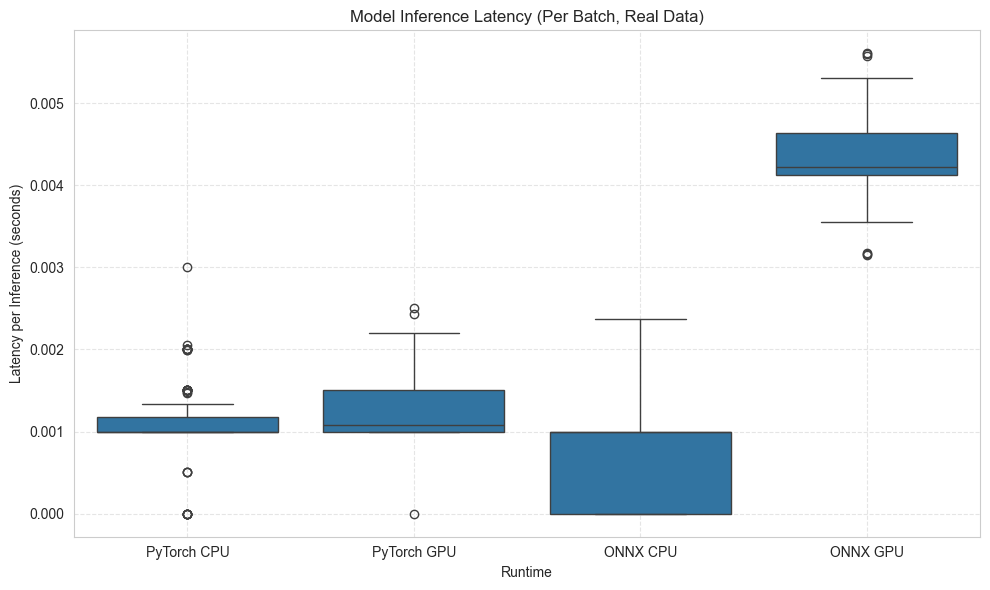


📋 Dynamics Model Latency Summary (ms):
    Runtime   Mean  Median  Std_Dev    P90    Min    Max
   ONNX CPU 0.6979  0.9997   0.5536 1.3026 0.0000 2.3692
   ONNX GPU 4.4243  4.2173   0.5359 5.2143 3.1531 5.6045
PyTorch CPU 1.1072  1.0003   0.4901 1.9933 0.0000 3.0012
PyTorch GPU 1.2900  1.0769   0.4313 2.0026 0.0000 2.5091


In [22]:
from itertools import islice

csv_train_folder  = "logs_augmented/train"
full_drive_csv    = "logs_augmented/test/sim_B5_mapTown05_soc1.0_temp30C_20250514_120440_aug.csv"

dynamics = DynamicsModel(
    state_dim=state_dim,
    action_dim=action_dim,
    num_layers=num_layers,
    hidden_size=hidden_size
).to(DEVICE)
dynamics.load_state_dict(torch.load(model, map_location=DEVICE))


# Create test loader
test_loader, _, feature_cols, _ = make_loaders(
    csv_dir=csv_test_dir,
    unnormalised_cols=unnormalised_cols,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    transformer=ct,
    batch_size=1,
    seq_len=seq_len,
    action_cols=action_cols,
    test=True
)
test_loader = list(islice(test_loader, 100))

df = run_benchmark_with_loader(dynamics, test_loader)
print(df.groupby("Runtime").describe(percentiles=[.5])["Latency (s)"])
plot_results(df)
summary_table = print_latency_summary(df)

In [23]:
export_latency_table(summary_table, to_latex=True, to_markdown=False)


📄 LaTeX Table:
\begin{tabular}{lrrrrrr}
\toprule
Runtime & Mean & Median & Std_Dev & P90 & Min & Max \\
\midrule
ONNX CPU & 0.697939 & 0.999689 & 0.553598 & 1.302624 & 0.000000 & 2.369165 \\
ONNX GPU & 4.424276 & 4.217267 & 0.535948 & 5.214262 & 3.153086 & 5.604506 \\
PyTorch CPU & 1.107244 & 1.000285 & 0.490075 & 1.993299 & 0.000000 & 3.001213 \\
PyTorch GPU & 1.289997 & 1.076937 & 0.431255 & 2.002645 & 0.000000 & 2.509117 \\
\bottomrule
\end{tabular}



In [24]:
def interpolate_latency_tops(df, tops_reference, tops_targets):
    """
    df: pandas DataFrame with columns ['Runtime', 'Latency (s)']
    tops_reference: float, TOPS of your current benchmarking hardware (e.g., RTX 3060 = 13)
    tops_targets: dict of target platform names to their TOPS (e.g., {'Jetson NX': 6, 'AGX Orin': 254})

    Returns:
        A new DataFrame with interpolated latencies for each platform.
    """
    interpolated = df.copy()

    for name, target_tops in tops_targets.items():
        scale = tops_reference / target_tops
        interpolated[f"{name} (Est)"] = interpolated["Latency (s)"] * scale

    return interpolated

In [30]:
tops_reference = 1406 # RTX 5070 Ti TOPS 
tops_targets = {
    "Jetson Nano 4GB": 0.472,
    "Jetson Xavier NX": 21,
    "Jetson Orin Nano 8GB": 67,
    "Jetson AGX Orin 32GB": 200,
}


# 1. Summarize the original latency results by runtime (mean latency per runtime)
mean_latency_df = df.groupby("Runtime", as_index=False)["Latency (s)"].mean()

# 2. Interpolate those
df_interp = interpolate_latency_tops(mean_latency_df, tops_reference, tops_targets)


def print_interpolated_latency_summary(df_interp):
    # Make a copy to avoid modifying original
    summary = df_interp.copy()
    
    # Convert only the original latency column to milliseconds
    summary = summary.rename(columns={'Latency (s)': 'Latency (ms)'})
    summary['Latency (ms)'] = summary['Latency (ms)'] * 1000
    
    print("\n📊 Interpolated Latencies for Target Platforms (ms):")
    print(summary.to_string(index=False, float_format="{:.4f}".format))
    
    return summary


print("\n📊 Interpolated Latencies for Target Platforms:")
summary_table = print_interpolated_latency_summary(df_interp)
export_latency_table(summary_table, to_latex=True, to_markdown=False)


📊 Interpolated Latencies for Target Platforms:

📊 Interpolated Latencies for Target Platforms (ms):
    Runtime  Latency (ms)  Jetson Nano 4GB (Est)  Jetson Xavier NX (Est)  Jetson Orin Nano 8GB (Est)  Jetson AGX Orin 32GB (Est)  Latency (ms)
   ONNX CPU        0.0007                 2.0790                  0.0467                      0.0146                      0.0049        0.6979
   ONNX GPU        0.0044                13.1791                  0.2962                      0.0928                      0.0311        4.4243
PyTorch CPU        0.0011                 3.2983                  0.0741                      0.0232                      0.0078        1.1072
PyTorch GPU        0.0013                 3.8427                  0.0864                      0.0271                      0.0091        1.2900

📄 LaTeX Table:
\begin{tabular}{lrrrrrr}
\toprule
Runtime & Latency (ms) & Jetson Nano 4GB (Est) & Jetson Xavier NX (Est) & Jetson Orin Nano 8GB (Est) & Jetson AGX Orin 32GB (Est) & La

In [26]:
def generate_memory_estimate_table(
    state_dim=22,
    action_dim=2,
    hidden_dim=128,
    num_layers=2,
    seq_len=64,
    dtype_list=('float32', 'float16', 'int8'),
    buffer_sizes=(50_000, 100_000, 250_000, 500_000, 1_000_000)
):
    dtype_sizes = {
        'float32': 4,
        'float16': 2,
        'int8': 1
    }

    results = []

    for dtype in dtype_list:
        size_per_float = dtype_sizes[dtype]
        state_size = seq_len * state_dim * size_per_float
        action_size = seq_len * action_dim * size_per_float
        next_state_size = seq_len * state_dim * size_per_float
        reward_size = seq_len * 1 * size_per_float
        done_size = seq_len * 1 * size_per_float
        hidden_size = 2 * num_layers * hidden_dim * size_per_float

        per_sequence_bytes = state_size + action_size + next_state_size + reward_size + done_size + hidden_size

        for num_sequences in buffer_sizes:
            total_bytes = per_sequence_bytes * num_sequences
            mem_mb = total_bytes / (1024 ** 2)
            mem_gb = total_bytes / (1024 ** 3)

            results.append({
                'DType': dtype,
                'Buffer Size': num_sequences,
                'Total MB': round(mem_mb, 2),
                'Total GB': round(mem_gb, 2)
            })

    df = pd.DataFrame(results)
    return df

In [27]:
def plot_memory_usage(df):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="Buffer Size", y="Total GB", hue="DType")
    plt.title("Estimated Memory Usage for Experience Buffer")
    plt.ylabel("Memory (GB)")
    plt.xlabel("Buffer Size (Sequences)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


📊 Memory Usage Estimates for Experience Buffer:


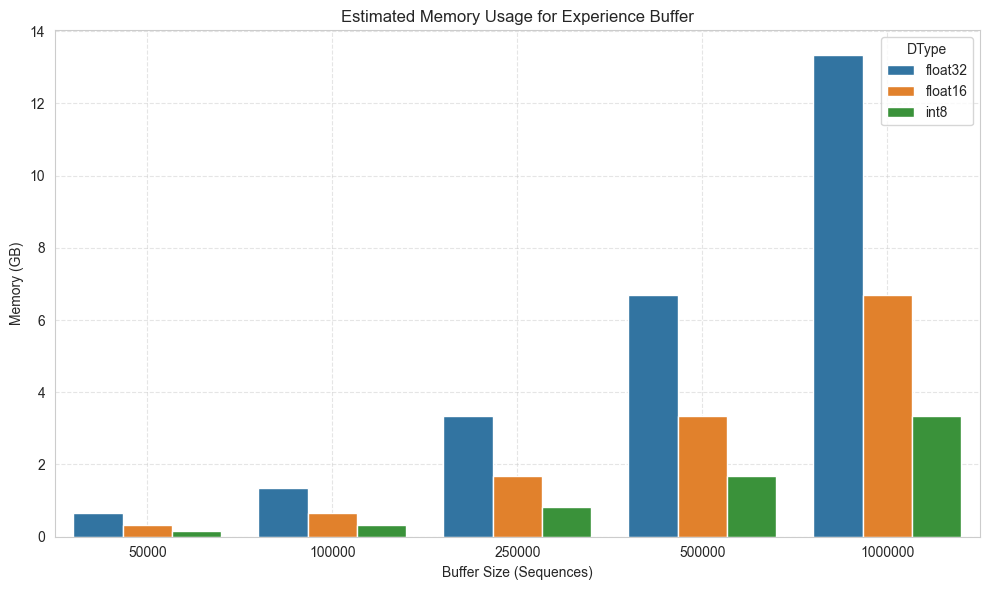


📄 LaTeX Table:
\begin{tabular}{lrrr}
\toprule
DType & Buffer Size & Total MB & Total GB \\
\midrule
float32 & 50000 & 683.590000 & 0.670000 \\
float32 & 100000 & 1367.190000 & 1.340000 \\
float32 & 250000 & 3417.970000 & 3.340000 \\
float32 & 500000 & 6835.940000 & 6.680000 \\
float32 & 1000000 & 13671.880000 & 13.350000 \\
float16 & 50000 & 341.800000 & 0.330000 \\
float16 & 100000 & 683.590000 & 0.670000 \\
float16 & 250000 & 1708.980000 & 1.670000 \\
float16 & 500000 & 3417.970000 & 3.340000 \\
float16 & 1000000 & 6835.940000 & 6.680000 \\
int8 & 50000 & 170.900000 & 0.170000 \\
int8 & 100000 & 341.800000 & 0.330000 \\
int8 & 250000 & 854.490000 & 0.830000 \\
int8 & 500000 & 1708.980000 & 1.670000 \\
int8 & 1000000 & 3417.970000 & 3.340000 \\
\bottomrule
\end{tabular}



In [28]:
# Generate the table
memory_table = generate_memory_estimate_table()

# Print the table
print("\n📊 Memory Usage Estimates for Experience Buffer:")
plot_memory_usage(memory_table)
export_latency_table(memory_table, to_latex=True, to_markdown=False)